In [97]:
import unicodedata
import re
import json
import os
from requests import get
from bs4 import BeautifulSoup
import acquire
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk.sentiment

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import pandas as pd
from acquire import parse_blog
from acquire import get_article_text
from acquire import get_codeup_blogs
from acquire import get_inshorts_articles
from acquire import prep_text

In [2]:
# Store contents of 'spam.csv' into a variable
spam = pd.read_csv('spam.csv')

In [3]:
# Check column names.
spam.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
# Drop unwanted columns.
spam.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [5]:
# Rename columns.
spam.rename(columns={'v1':'label','v2':'text'}, inplace=True)

In [6]:
spam

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will �_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
# Add words to append to list of stopwords.
ADDITIONAL_STOPWORDS = ['r','u','2','ltgt']

# This function will append list of words to stopwords
def clean(text):
    # Create lemmatizer object
    wnl = nltk.stem.WordNetLemmatizer()
    # Create list of stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    # Convert string to ASCII character set.
    text = (unicodedata.normalize('NFKD', text)
           .encode('ascii','ignore')
           .decode('utf-8','ignore')
           .lower())
    # Remove special characters.
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [8]:
# This function shows number of words and their ratio of occurence.
def show_counts_and_ratios(df, column):
    labels = pd.concat([spam.label.value_counts(),
                       spam.label.value_counts(normalize=True)], axis =1)
    labels.columns = ['n', 'percent']
    return labels

In [9]:
show_counts_and_ratios(spam, 'label')

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [10]:
# Convert dataframe into text.
ham_words = clean(' '.join(spam[spam.label == 'ham'].text))
spam_words = clean(' '.join(spam[spam.label == 'spam'].text))
all_words = clean(' '.join(spam.text))

In [11]:
# Check top 5 words in each list.
ham_words[:5], spam_words[:5], all_words[:5]

(['go', 'jurong', 'point', 'crazy', 'available'],
 ['free', 'entry', 'wkly', 'comp', 'win'],
 ['go', 'jurong', 'point', 'crazy', 'available'])

In [12]:
# Get value counts of each word in each list.
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [13]:
pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)

,0,1,2
0,3,NaN,3.0
008704050406,2,NaN,2.0
0089my,1,NaN,1.0
0121,1,NaN,1.0
01223585236,1,NaN,1.0
...,...,...,...
zoe,2,1.0,1.0
zogtorius,1,1.0,NaN
zoom,1,1.0,NaN
zouk,1,NaN,1.0


In [14]:
# Combine value counts of words into one dataframe to work on

word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
              .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
              .fillna(0) 
              .apply(lambda s: s.astype(int)))

word_counts

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1
...,...,...,...
zoe,2,1,1
zogtorius,1,1,0
zoom,1,1,0
zouk,1,0,1


### Are there any words that uniquely identify a spam or ham message?

In [15]:
pd.concat([word_counts[word_counts.ham == 0].sort_values(by='spam', ascending=False).head(10),
          word_counts[word_counts.spam == 0].sort_values(by='ham', ascending=False).head(10)])

,all,ham,spam
claim,115,0,115
prize,94,0,94
tone,73,0,73
guaranteed,50,0,50
500,44,0,44
18,43,0,43
150,39,0,39
awarded,38,0,38
150ppm,34,0,34
ringtone,27,0,27


### What are the most frequently occuring words?

In [16]:
word_counts.sort_values(by='all', ascending=False)

,all,ham,spam
call,600,241,359
im,471,458,13
get,397,314,83
ur,384,240,144
go,304,273,31
...,...,...,...
lyricalladie21f,1,0,1
lyric,1,1,0
lyk,1,1,0
lying,1,1,0


## Visualization

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20most common words')

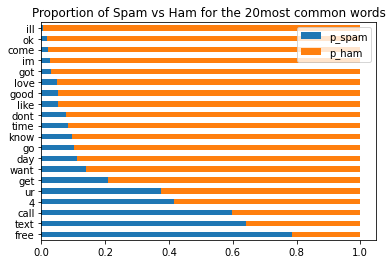

In [18]:
# Plot the ratios of spam and ham words.
(word_counts
.assign(p_spam=word_counts.spam / word_counts['all'],
        p_ham=word_counts.ham / word_counts['all'])
.sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20most common words')

In [19]:
# Get values and ratios of all words that have a value count greater than 10.
(word_counts
[(word_counts.spam > 10) & (word_counts.ham > 10)]
.assign(ratio=lambda df: df.spam / (df.ham + .01))
.sort_values(by='ratio')
.pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,471,458,13,0.028384
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,290,268,22,0.082086
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


(-0.5, 399.5, 199.5, -0.5)

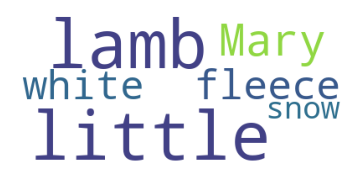

In [20]:
from wordcloud import WordCloud

# Create sentence for wordcloud
sentence = "Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow."

# Generate the image using previously stored sentence.
img = WordCloud(background_color='white').generate(sentence)

# Display image.
plt.imshow(img)
plt.axis('off')

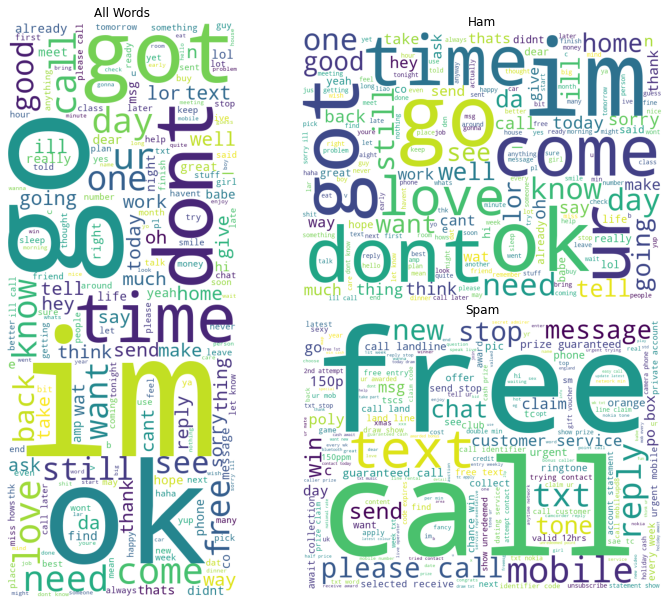

In [21]:
# Generate images from joining all words in the list into one 'sentence' using '.join'
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10,8))
axs = [plt.axes([0,0,.5,1]), plt.axes([.5,.5,.5,.5]), plt.axes([.5,0,.5,.5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

## Bigrams

In [22]:
sentence = "Mary had a little lamb"

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)

[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

In [23]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                     .value_counts()
                     .head(20))

top_20_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       33
(good, morning)    31
(new, year)        30
(im, going)        26
(take, care)       26
(pls, send)        22
(ok, lor)          22
(im, gonna)        20
(good, night)      19
(happy, new)       19
(hi, hi)           18
(wat, time)        18
(last, night)      18
(great, day)       17
(dont, want)       15
(want, go)         15
dtype: int64

In [24]:
top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])

0       call later
1         ill call
2         let know
3        sorry ill
4        dont know
5     good morning
6         new year
7         im going
8        take care
9         pls send
10          ok lor
11        im gonna
12      good night
13       happy new
14           hi hi
15        wat time
16      last night
17       great day
18       dont want
19         want go
Name: index, dtype: object

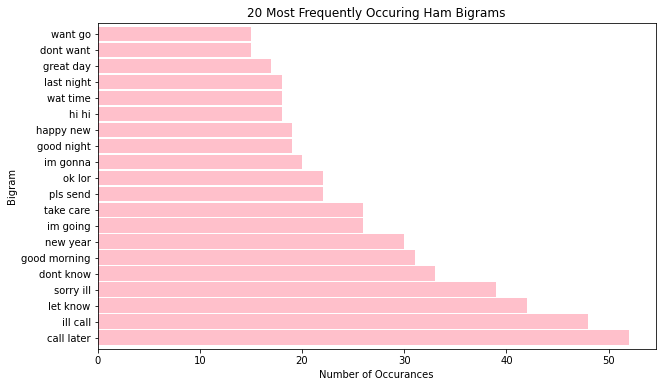

In [25]:
top_20_ham_bigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Ham Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

ticks , _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

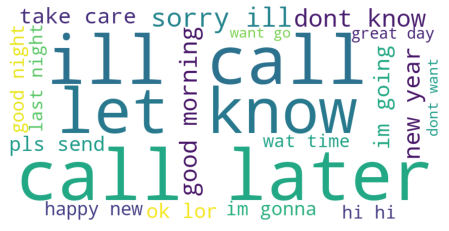

In [26]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [27]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(1000, cash)            25
(po, box)               24
(guaranteed, call)      23
(prize, guaranteed)     22
(every, week)           19
(selected, receive)     19
(await, collection)     19
(chance, win)           19
(send, stop)            19
(show, 800)             18
(urgent, mobile)        18
(land, line)            18
(valid, 12hrs)          17
(claim, call)           17
(call, 08000930705)     16
(account, statement)    16
(sae, tc)               16
(prize, claim)          16
dtype: int64

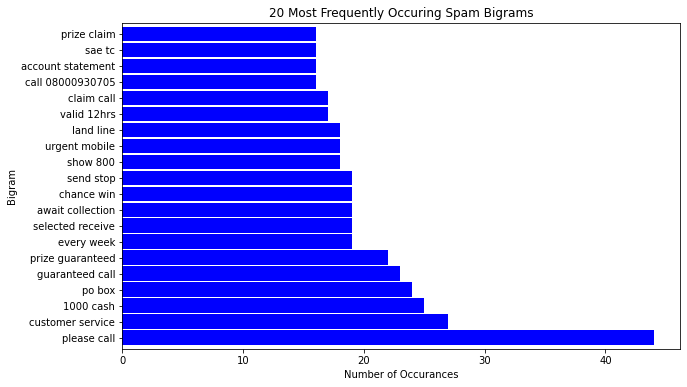

In [28]:
top_20_spam_bigrams.plot.barh(color='blue', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Spam Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

# Make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

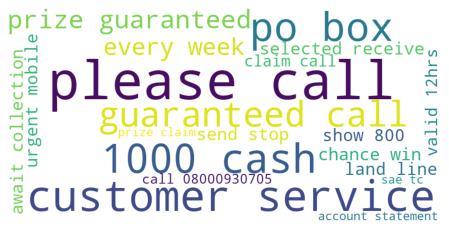

In [29]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Create and explore with trigrams(i.e. an n-gram with an n of 3) for both the spam and ham data.

In [30]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                     .value_counts()
                     .head(20))

top_20_ham_trigrams

(ill, call, later)             42
(sorry, ill, call)             38
(happy, new, year)             19
(pls, send, message)           13
(phone, right, pls)            12
(pick, phone, right)           12
(right, pls, send)             12
(cant, pick, phone)            12
(hi, hi, hi)                   11
(x, x, x)                       8
(good, morning, dear)           7
(pls, convey, birthday)         6
(kiss, across, sea)             6
(call, later, meeting)          6
(convey, birthday, wish)        6
(callertune, caller, press)     5
(happy, bday, bos)              5
(4, lunch, lunch)               5
(love, go, day)                 5
(came, 5, minuts)               5
dtype: int64

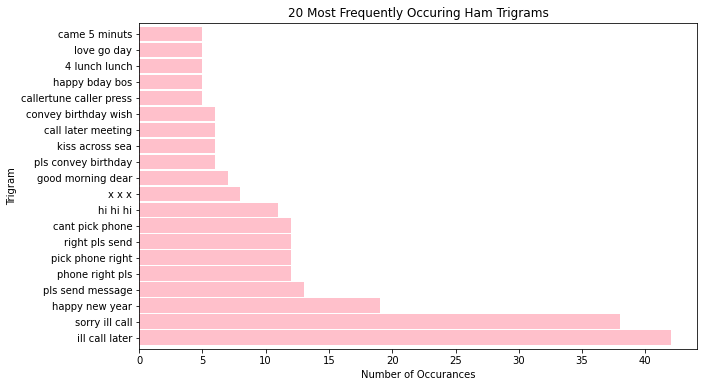

In [31]:
top_20_ham_trigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Ham Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')

ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

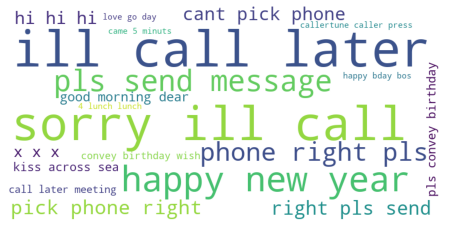

In [32]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [33]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams

(prize, guaranteed, call)              21
(call, customer, service)              15
(land, line, claim)                    14
(reply, call, 08000930705)             14
(2003, account, statement)             13
(private, 2003, account)               13
(guaranteed, 1000, cash)               12
(camcorder, reply, call)               12
(show, 800, unredeemed)                12
(every, week, txt)                     11
(please, call, customer)               11
(urgent, trying, contact)              11
(anytime, network, min)                11
(bonus, caller, prize)                 11
(tone, 4, ur)                          11
(cash, await, collection)              10
(2000, bonus, caller)                  10
(1000, cash, 2000)                     10
(customer, service, representative)    10
(speak, live, operator)                10
dtype: int64

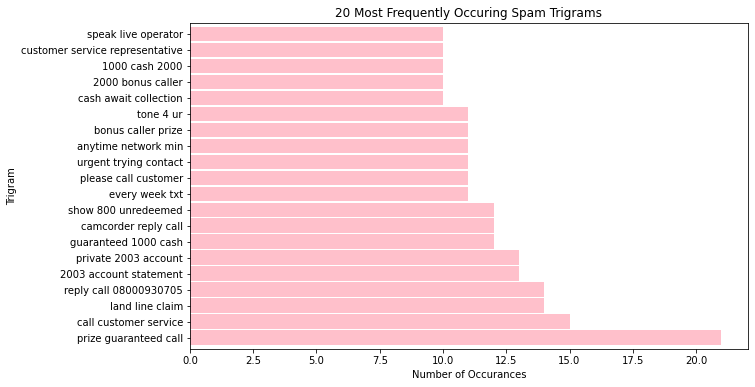

In [34]:
top_20_spam_trigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Spam Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')

ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

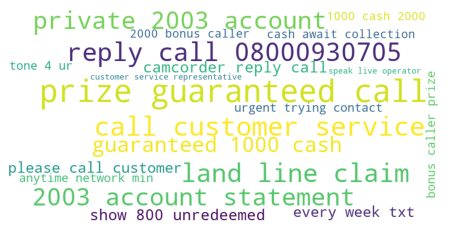

In [35]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [36]:
# Acquire Codeup blogs.
codeup_df = acquire.get_codeup_blogs(cached=True)

In [37]:
codeup_df

,title,date & source,original
0,Codeup Dallas Open House,"Nov 30, 2021 | Dallas Newsletter, Events",\nCome join us for the re-opening of our Dalla...
1,Codeup’s Placement Team Continues Setting Records,"Nov 19, 2021 | Codeup News, Employers",\n\n\n\n\n\nOur Placement Team is simply defin...
2,"IT Certifications 101: Why They Matter, and Wh...","Nov 18, 2021 | IT Training, Tips for Prospecti...","\n\n\n\n\n\nAWS, Google, Azure, Red Hat, CompT..."
3,A rise in cyber attacks means opportunities fo...,"Nov 17, 2021 | Cybersecurity","\nIn the last few months, the US has experienc..."
4,Use your GI Bill® benefits to Land a Job in Tech,"Nov 4, 2021 | Codeup News, Tips for Prospectiv...",\n\n\n\n\n\nAs the end of military service get...
5,Which program is right for me: Cyber Security ...,"Oct 28, 2021 | IT Training, Tips for Prospecti...",\n\n\n\n\n\nWhat IT Career should I choose?\nI...
6,What the Heck is System Engineering?,"Oct 21, 2021 | IT Training, Tips for Prospecti...",\n\n\n\n\n\nCodeup offers a 13-week training p...
7,From Speech Pathology to Business Intelligence,"Oct 18, 2021 | Alumni Stories",\n\n\n\n\n\nBy: Alicia Gonzalez\nBefore Codeup...
8,Boris – Behind the Billboards,"Oct 3, 2021 | Behind the Billboards",\n\n\n
9,Is Codeup the Best Bootcamp in San Antonio…or ...,"Sep 16, 2021 | Codeup News, Featured",\n\n\n\n\n\nLooking for the best data science ...


In [38]:
# Acquire inshorts articles.
news_df = get_inshorts_articles()

In [39]:
# Verify data acquisition.
news_df

,title,author,original,date,category
0,Rare volcanic storm sends bolts of lightning i...,Pragya Swastik,Mount Etna's eruption created a volcanic storm...,2022-02-13,science
1,"1st images captured by the world's biggest, mo...",Anmol Sharma,NASA has shared the first-ever images captured...,2022-02-12,science
2,NASA shares video of storms that look like piz...,Sakshita Khosla,NASA recently shared a video showing an infrar...,2022-02-12,science
3,Countdown begins for ISRO'S first launch missi...,Sakshita Khosla,The countdown for the launch of PSLV-C52 that'...,2022-02-13,science
4,"46-inch fully woven, smart display created by ...",Hiral Goyal,University of Cambridge-led researchers have c...,2022-02-14,science
...,...,...,...,...,...
118,Anubhav Sinha one of the finest filmmakers: Ra...,Ramanpreet Singh Virdi,Actor Rajkummar Rao has said he was waiting to...,2022-02-13,entertainment
119,'Fitoor' has been significant learning curve i...,Amartya Sharma,Director Abhishek Kapoor has said that his 201...,2022-02-13,entertainment
120,"Gave 4-5,000 auditions; sat home & cried, slap...",Kriti Kambiri,Television actor Aditya Dekhmukh has called 20...,2022-02-13,entertainment
121,Rapper Blueface arrested for owning concealed ...,Ramanpreet Singh Virdi,American rapper Blueface was recently arrested...,2022-02-13,entertainment


In [40]:
# Call 'prep_text' function to clean, stem, and lemmatize the text.
prep_text(news_df, 'original', extra_words=["'", ',','said','added'])

,category,original,stemmed,lemmatized
0,science,Mount Etna's eruption created a volcanic storm...,mount etna erupt creat volcan storm sent bolt ...,mount etna eruption created volcanic storm sen...
1,science,NASA has shared the first-ever images captured...,nasa ha share firstev imag captur jame webb sp...,nasa ha shared firstever image captured james ...
2,science,NASA recently shared a video showing an infrar...,nasa recent share video show infrar view north...,nasa recently shared video showing infrared vi...
3,science,The countdown for the launch of PSLV-C52 that'...,countdown launch pslvc52 carri three satellit ...,countdown launch pslvc52 carrying three satell...
4,science,University of Cambridge-led researchers have c...,univers cambridgel research creat 46inch fulli...,university cambridgeled researcher created 46i...
...,...,...,...,...
118,entertainment,Actor Rajkummar Rao has said he was waiting to...,actor rajkummar rao ha wa wait collabor direct...,actor rajkummar rao ha wa waiting collaborate ...
119,entertainment,Director Abhishek Kapoor has said that his 201...,director abhishek kapoor ha hi 2016 film fitoo...,director abhishek kapoor ha 2016 film fitoor h...
120,entertainment,Television actor Aditya Dekhmukh has called 20...,televis actor aditya dekhmukh ha call 2017 wor...,television actor aditya dekhmukh ha called 201...
121,entertainment,American rapper Blueface was recently arrested...,american rapper bluefac wa recent arrest posse...,american rapper blueface wa recently arrested ...


In [41]:
# Check original content.
news_df.original[3]

"The countdown for the launch of PSLV-C52 that's carrying three satellites, began on Sunday morning. Scheduled for Monday at 5:59 am, this will be the space agency's first launch mission of 2022. The launch vehicle will take off from Satish Dhawan Space Centre in Sriharikota in Andhra Pradesh."

## Create a separate dataframe for each category.

In [42]:
# Set viewing options.
pd.set_option('display.max_colwidth', None)

In [43]:
# Create a separate dataframe for each category and store it into a list.
list_of_dfs = []
for cat in news_df.category.unique():
    list_of_dfs.append(news_df[news_df.category == cat])

In [44]:
news_df.clean[0:21]

0                                                                               mount etna eruption created volcanic storm sent bolts lightning across sky eastern sicily volcanic expert volcanic storms rare happen particularly violent eruptions volcanoes located near sea eruption took place earlier week shot ash 10 km air sea level
1                                                                                                   nasa shared firstever images captured james webb space telescope includes selfie primary mirror one image mosaic released nasa shows 18 little white dots dot different view isolated star image included selfie telescope primary mirror
2                                                                            nasa recently shared video showing infrared view north pole jupiter showed storms resembled pizza topping pepperoni calling phenomenon pepperoni storms nasa explained yellow areas warmer deeper jupiter atmosphere dark areas colder higher jupiter atmospher

In [45]:
news_df.lemmatized[0:4]

0        mount etna eruption created volcanic storm sent bolt lightning across sky eastern sicily volcanic expert volcanic storm rare happen particularly violent eruption volcano located near sea eruption took place earlier week shot ash 10 km air sea level
1                       nasa ha shared firstever image captured james webb space telescope includes selfie primary mirror one image mosaic released nasa show 18 little white dot dot different view isolated star image included selfie telescope primary mirror
2    nasa recently shared video showing infrared view north pole jupiter showed storm resembled pizza topping pepperoni calling phenomenon pepperoni storm nasa explained yellow area warmer deeper jupiter atmosphere dark area colder higher jupiter atmosphere
3                                                    countdown launch pslvc52 carrying three satellite began sunday morning scheduled monday 559 space agency first launch mission 2022 launch vehicle take satish dhawan space ce

In [46]:
news_df.stemmed[0:4]

0    mount etna erupt creat volcan storm sent bolt lightn across sky eastern sicili volcan expert volcan storm rare happen particularli violent erupt volcano locat near sea erupt took place earlier thi week shot ash 10 km air abov sea level
1                                 nasa ha share firstev imag captur jame webb space telescop includ selfi primari mirror one imag mosaic releas nasa show 18 littl white dot dot differ view isol star imag includ selfi telescop primari mirror
2                nasa recent share video show infrar view north pole jupit show storm resembl pizza top pepperoni call phenomenon pepperoni storm nasa explain yellow area warmer deeper jupit atmospher dark area colder higher jupit atmospher
3                                           countdown launch pslvc52 carri three satellit began sunday morn schedul monday 559 thi space agenc first launch mission 2022 launch vehicl take satish dhawan space centr sriharikota andhra pradesh
Name: stemmed, dtype: object

# Takeaways
* There is not much difference between the lemmatized and clean versions. The stemmed version is difficult for me to understand. 
* I will work on the clean version of text for exploration.

In [47]:
news_df.category.unique()

array(['science', 'business', 'sports', 'technology', 'entertainment'],
      dtype=object)

In [48]:
# Create a corpus of words for each category.
science_words = ' '.join(news_df[news_df.category == 'science'].clean)
business_words = ' '.join(news_df[news_df.category == 'business'].clean)
sports_words = ' '.join(news_df[news_df.category == 'sports'].clean)
technology_words = ' '.join(news_df[news_df.category == 'technology'].clean)
entertainment_words = ' '.join(news_df[news_df.category == 'entertainment'].clean)
all_words = ' '.join(news_df.clean)

In [49]:
len(science_words), len(business_words), len(sports_words), len(technology_words), len(entertainment_words), len(all_words)

(7125, 6858, 6157, 6528, 5782, 32454)

In [50]:
# Verify text is in the proper format.
science_words

'mount etna eruption created volcanic storm sent bolts lightning across sky eastern sicily volcanic expert volcanic storms rare happen particularly violent eruptions volcanoes located near sea eruption took place earlier week shot ash 10 km air sea level nasa shared firstever images captured james webb space telescope includes selfie primary mirror one image mosaic released nasa shows 18 little white dots dot different view isolated star image included selfie telescope primary mirror nasa recently shared video showing infrared view north pole jupiter showed storms resembled pizza topping pepperoni calling phenomenon pepperoni storms nasa explained yellow areas warmer deeper jupiter atmosphere dark areas colder higher jupiter atmosphere countdown launch pslvc52 carrying three satellites began sunday morning scheduled monday 559 space agency first launch mission 2022 launch vehicle take satish dhawan space centre sriharikota andhra pradesh university cambridgeled researchers created 46in

### Represent text as word frequencies

In [51]:
# Get frequencies of each word within a category.
science_freq = pd.Series(science_words.split()).value_counts()
business_freq = pd.Series(business_words.split()).value_counts()
sports_freq = pd.Series(sports_words.split()).value_counts()
technology_freq = pd.Series(technology_words.split()).value_counts()
entertainment_freq = pd.Series(entertainment_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [52]:
word_counts = pd.concat([science_freq, business_freq, sports_freq, technology_freq, entertainment_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['science','business','sports','technology','entertainment','all']

In [53]:
word_counts

,science,business,sports,technology,entertainment,all
researchers,9,0,0,3,0,12
years,8,4,0,2,1,15
energy,8,0,0,2,0,10
found,8,1,0,0,0,9
nasa,8,0,0,0,0,8
...,...,...,...,...,...,...
worst,0,0,0,0,1,1
every,0,0,0,0,1,1
separating,0,0,0,0,1,1
contained,0,0,0,0,1,1


In [54]:
word_counts['all'].sort_values(ascending=False)

crore       45
ipl         37
auction     36
2022        31
india       30
            ..
anupam       1
fourth       1
rise         1
act          1
spoilers     1
Name: all, Length: 2412, dtype: int64

### Visualization
Visualize the top 5 words and determine which category uses those words the most.

Text(0.5, 1.0, 'Top 10 Words for Science and Technology')

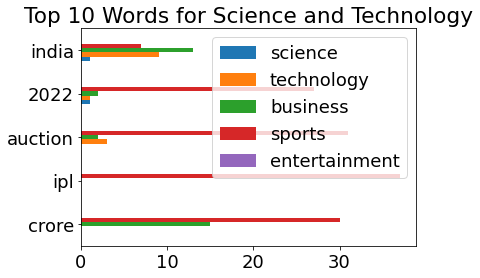

In [55]:
plt.rc('font', size=18)
word_counts.sort_values('all', ascending=False).head(5)[['science', 'technology', 'business', 'sports', 'entertainment']].plot.barh()
plt.title('Top 10 Words for Science and Technology')

# Takeaways
**Out of all words in all categories:**
* 'said' and 'added'(another form of 'said') are the most common words.
* Sports news includes 'India' the most.
* Business mentions 'crore' the most.
* The word 'billion' is used the most in technology articles.
* Sports and Entertainment use the word 'added' the most.

## Visualize the top 10 words for each category.

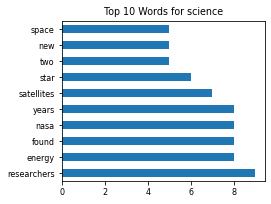

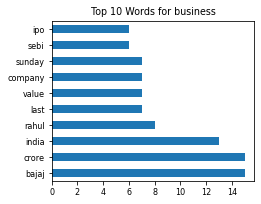

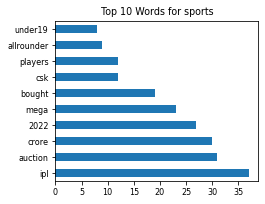

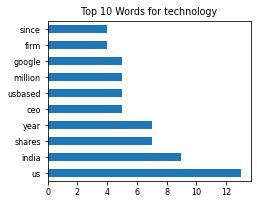

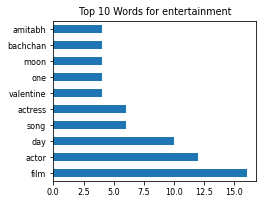

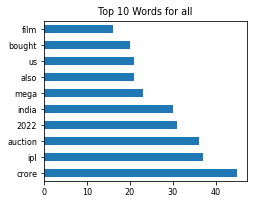

In [56]:
n = 1
for category in list(word_counts.columns):
    plt.rc('font', size=8)
    plt.figure(figsize=(8,10))
    plt.subplot(3,2,n)
    word_counts[category].sort_values(ascending=False).head(10).plot.barh()
    plt.title(f'Top 10 Words for {category}')
    n += 1

# Takeaways
* 'said' and 'added'(another form of said) are the most commonly used words in news.
* The news is a lot of 'He said/She said/They said"
* Actor is mentioned more than actress in entertainment news.
* Entertainment likes to mention films and Instagram.
* Meta and Facebook dominated technology news.
* Sports news uses "India" more than any other category.
* NASA and space are mentioned a lot in science news.

In [57]:
# View list of stopwords.
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

* Find the top 10 longest words for each category.
* Find the average word length for each category.
* Find words that are unique to each category.

In [58]:
# Get length of total characters in all cleaned science articles.
len(science_words)

7125

In [59]:
# Get wordcount of all words in cleaned science articles.
len(science_words.split())

944

In [60]:
# Get list of unique words and a count in cleaned science articles.
unique_words = pd.DataFrame(science_words.split())[0].unique()

len(unique_words)

682

In [61]:
# Get average word length of all unique words in cleaned science articles.
pd.Series([len(word) for word in unique_words]).mean()

6.696480938416422

Text(0.5, 1.0, 'Number of Characters in Each Word')

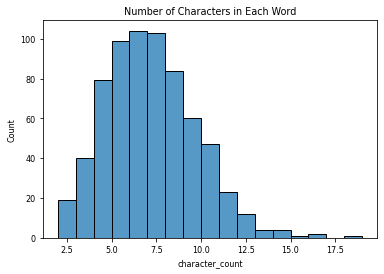

In [62]:
# Get length of every unique word and plot a histogram of how many times each length of word appears.
sns.histplot([len(word) for word in unique_words], binwidth=1)
plt.xlabel('character_count')
plt.title('Number of Characters in Each Word')

# Takeaways
* The distribution of word length is slightly right skewed.

In [63]:
def analyze_text(string):
    # Get length of total characters in all cleaned science articles.
    total_characters = len(string)
    print(f'Total amount of characters: {total_characters}')
    
    # Get wordcount of all words in cleaned science articles.
    total_words = len(string.split())
    print(f'Total amount of words: {total_words}')
    
    # Get list of unique words and a count in cleaned science articles.
    unique_words = pd.DataFrame(string.split())[0].unique()
    print('Total amount of unique words: ',len(unique_words))

    # Get average word length of all words in cleaned science articles.
    avg_wordlength = round(pd.Series([len(word) for word in unique_words]).mean(), 1)
    print('Average word length: ', avg_wordlength)
    
    # Get the ratio of unique words
    unique_ratio = len(unique_words) / (total_words)
    print('The ratio of unique words: ', unique_ratio)
    
    # Get length of every unique word and plot a histogram of how many times each length of word appears.
    list_of_graph_titles = news_df.category.unique()
    plt.figure(figsize=(10,8))
    sns.histplot([len(word) for word in unique_words], binwidth=1)
    plt.xlabel('character_count')
    plt.title('Number of Characters in Each Word')

Total amount of characters: 7125
Total amount of words: 944
Total amount of unique words:  682
Average word length:  6.7
The ratio of unique words:  0.722457627118644


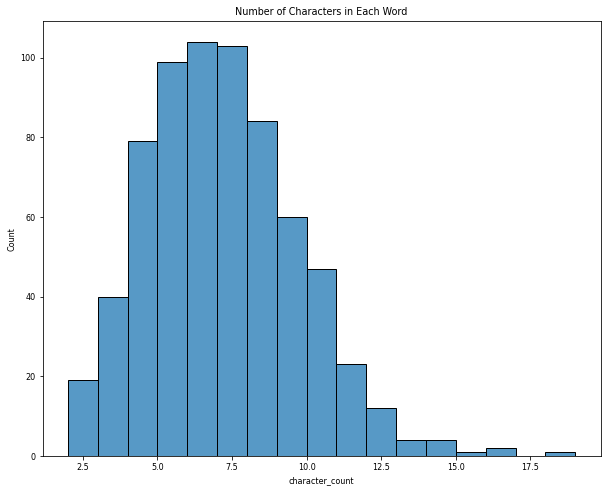

In [64]:
analyze_text(science_words)

In [65]:
news_df

,title,author,original,date,category,clean,stemmed,lemmatized
0,Rare volcanic storm sends bolts of lightning in sky during Mount Etna eruption,Pragya Swastik,"Mount Etna's eruption created a volcanic storm that sent bolts of lightning across the sky over eastern Sicily. A volcanic expert said such volcanic storms are rare but can happen in particularly violent eruptions or with volcanoes located near the sea. The eruption, that took place earlier this week, shot ash 10 km into the air above sea level.",2022-02-13,science,mount etna eruption created volcanic storm sent bolts lightning across sky eastern sicily volcanic expert volcanic storms rare happen particularly violent eruptions volcanoes located near sea eruption took place earlier week shot ash 10 km air sea level,mount etna erupt creat volcan storm sent bolt lightn across sky eastern sicili volcan expert volcan storm rare happen particularli violent erupt volcano locat near sea erupt took place earlier thi week shot ash 10 km air abov sea level,mount etna eruption created volcanic storm sent bolt lightning across sky eastern sicily volcanic expert volcanic storm rare happen particularly violent eruption volcano located near sea eruption took place earlier week shot ash 10 km air sea level
1,"1st images captured by the world's biggest, most powerful telescope; NASA shares pics",Anmol Sharma,"NASA has shared the first-ever images captured from its James Webb Space Telescope, which includes a 'selfie' of its primary mirror. One image mosaic released by NASA shows 18 little white dots, with each dot being a different view of the same isolated star. The other image included a 'selfie' of the telescope's primary mirror.",2022-02-12,science,nasa shared firstever images captured james webb space telescope includes selfie primary mirror one image mosaic released nasa shows 18 little white dots dot different view isolated star image included selfie telescope primary mirror,nasa ha share firstev imag captur jame webb space telescop includ selfi primari mirror one imag mosaic releas nasa show 18 littl white dot dot differ view isol star imag includ selfi telescop primari mirror,nasa ha shared firstever image captured james webb space telescope includes selfie primary mirror one image mosaic released nasa show 18 little white dot dot different view isolated star image included selfie telescope primary mirror
2,NASA shares video of storms that look like pizza toppings at Jupiter's North Pole,Sakshita Khosla,"NASA recently shared a video showing an infrared view of the North Pole of Jupiter and it showed storms that resembled the pizza topping pepperoni. Calling the phenomenon ""pepperoni storms"", NASA explained, ""The yellow areas are warmer (or deeper into Jupiter's atmosphere) and the dark areas are colder (or higher up in Jupiter's atmosphere).""",2022-02-12,science,nasa recently shared video showing infrared view north pole jupiter showed storms resembled pizza topping pepperoni calling phenomenon pepperoni storms nasa explained yellow areas warmer deeper jupiter atmosphere dark areas colder higher jupiter atmosphere,nasa recent share video show infrar view north pole jupit show storm resembl pizza top pepperoni call phenomenon pepperoni storm nasa explain yellow area warmer deeper jupit atmospher dark area colder higher jupit atmospher,nasa recently shared video showing infrared view north pole jupiter showed storm resembled pizza topping pepperoni calling phenomenon pepperoni storm nasa explained yellow area warmer deeper jupiter atmosphere dark area colder higher jupiter atmosphere
3,Countdown begins for ISRO'S first launch mission of 2022 scheduled for tomorrow,Sakshita Khosla,"The countdown for the launch of PSLV-C52 that's carrying three satellites, began on Sunday morning. Scheduled for Monday at 5:59 am, this will be the space agency's first launch mission of 2022. The launch vehicle will take off from Satish Dhawan Space Centre in Sriharikota in Andhra Pradesh.",2022-02

In [66]:
list_of_category_words = [[science_words, business_words, sports_words, technology_words, entertainment_words]]

In [67]:
news_df.category.unique()

array(['science', 'business', 'sports', 'technology', 'entertainment'],
      dtype=object)

In [68]:
# Create a dataframe where each column consists of the total cleaned words for that particular category.
all_words_df = pd.DataFrame(list_of_category_words, columns=news_df.category.unique())

In [69]:
all_words_df

science  \
0  mount etna eruption created volcanic storm sent bolts lightning across sky eastern sicily volcanic expert volcanic storms rare happen particularly violent eruptions volcanoes located near sea eruption took place earlier week shot ash 10 km air sea level nasa shared firstever images captured james webb space telescope includes selfie primary mirror one image mosaic released nasa shows 18 little white dots dot different view isolated star image included selfie telescope primary mirror nasa recently shared video showing infrared view north pole jupiter showed storms resembled pizza topping pepperoni calling phenomenon pepperoni storms nasa explained yellow areas warmer deeper jupiter atmosphere dark areas colder higher jupiter atmosphere countdown launch pslvc52 carrying three satellites began sunday morning scheduled monday 559 space agency first launch mission 2022 launch vehicle take satish dhawan space centre sriharikota andhra pradesh university cambridgeled researchers created 46inch fully woven textile display smart sensors energy harvesting storage functionalities integrated fabric operate display monitor various inputs store energy later use researchers could lead curtains also tvs energyharvesting carpets interactive selfpowered clothing spacex billionaire ceo elon musk company starship rockets cost less 10 million per launch within 23 years may little million dollars per flightthese crazy low numbers space standards 394feet tall reusable spacecraft designed carry crew cargo longduration interplanetary flights nasa raised concerns spacex plan deploy 30000 satellites starlink saying could lead significant increase potential collisions low earth orbit satellites could cause possible impacts nasa spaceflight missions nasa noted currently 25000 total objects tracked onorbit spacex expansion add european scientists wednesday extracted recordbreaking 59 megajoules nuclear fusion energy energy powers stars uk atomic energy authority ukaea energy double achieved 1997 energy extracted fivesecond period uk facility nuclear fusion reaction two light nuclei merge form heavier nucleus arctic svalbard global seed vault receive new deposits february 14 gene banks sudan germany three others lebanonbased international center agricultural research dry areas icarda first organisation make withdrawal vault also deposit around 8000 samples home 11 million seed samples facility first opened 2008 researchers us europe early humans lived europe 54000 years ago 10000 years earlier previously believed found fossilized homo sapiens remains sandwiched remains neanderthals grotte de mandrin cave france rhone valley indicating two may coexisted earlier researchers believed arrival modern humans led neanderthals extinction nasa friday announced two new solar missions understand sun dynamics earthsun connection named multislit solar explorer muse helioswarm offer key information help protect astronauts communication signals satellites muse study heating sun corona helioswarm constellation nine spacecraft study solar wind turbulence chalk drum sculpture 5000 years ago discovered yorkshire uk british museum due displayed described important piece prehistoric art found britain last 100 years decorated motifs similar certain objects already display museum israeli scientists previous covid19 infection vaccination may improve performance antibodies researchers protection past infection lasts long breakthrough infections common six months post infection scientists compared immune response unvaccinated people recovered delta variant received two vaccines never infected brazil recorded deforestation ever amazon rainforest month january five times higher january 2021 government data showed deforestation brazil amazon totalled 430 square kilometres last month area seven times size manhattan new york highest january since current data series began 20152016 astronomers discovered extremely rare binary star system vanderbilt university one stars star 

In [70]:
all_words_df.columns

Index(['science', 'business', 'sports', 'technology', 'entertainment'], dtype='object')

science
Total amount of characters: 7125
Total amount of words: 944
Total amount of unique words:  682
Average word length:  6.7
The ratio of unique words:  0.722457627118644


business
Total amount of characters: 6858
Total amount of words: 951
Total amount of unique words:  632
Average word length:  6.5
The ratio of unique words:  0.6645636172450052


sports
Total amount of characters: 6157
Total amount of words: 930
Total amount of unique words:  471
Average word length:  6.1
The ratio of unique words:  0.5064516129032258


technology
Total amount of characters: 6528
Total amount of words: 872
Total amount of unique words:  632
Average word length:  6.7
The ratio of unique words:  0.7247706422018348


entertainment
Total amount of characters: 5782
Total amount of words: 798
Total amount of unique words:  562
Average word length:  6.4
The ratio of unique words:  0.7042606516290727




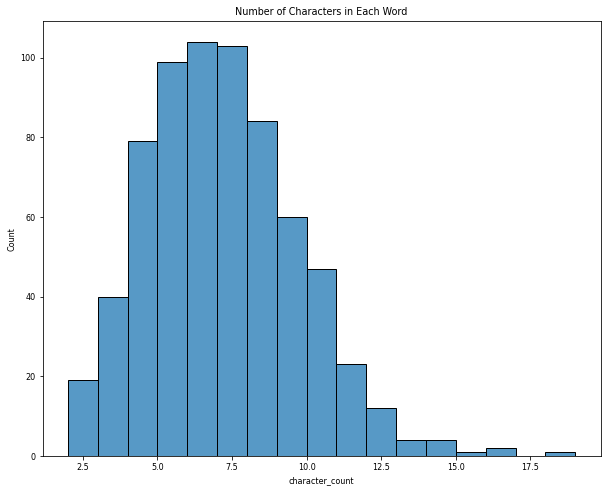

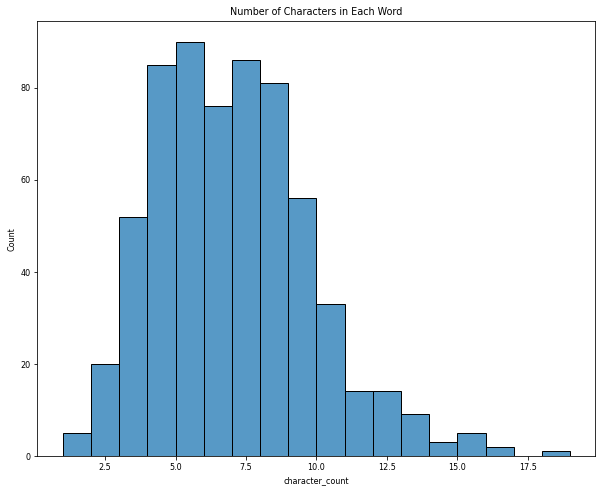

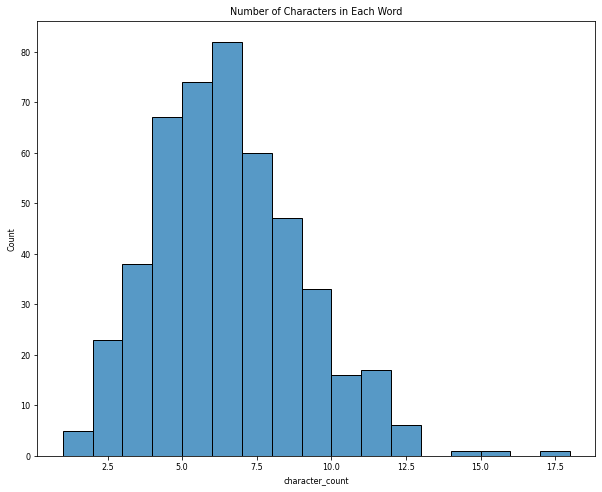

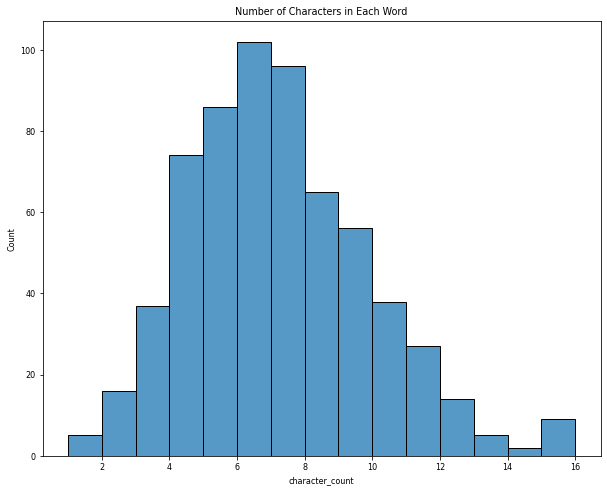

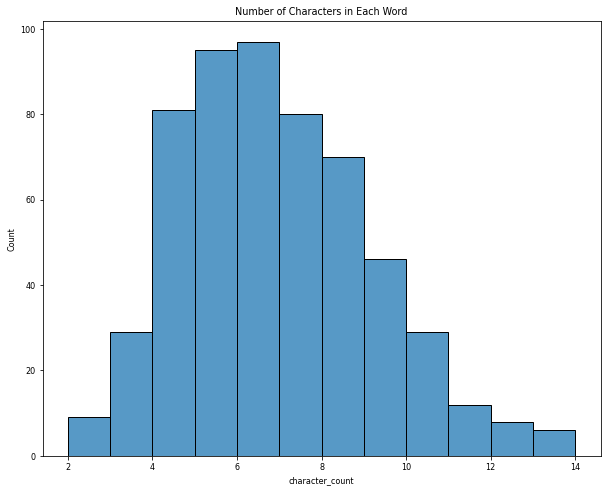

In [71]:
for column in all_words_df.columns:
    print(column)
    print('=========')
    all_words_df[column].apply(analyze_text)
    print('\n')

# Takeaways
* The science articles have the highest ratio of unique words and highest average word length.
* Ranking of categories based on ratio of unique words:
    * 1) Science
    * 2) Business
    * 3) Technology
    * 4) Sports
    * 5) Entertainment
* Ranking of categories based on average word length:
    * 1) Science
    * 2) Technology
    * 3) Business
    * 4) Sports & Entertainment

## Sentiment

In [72]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [73]:
sia.polarity_scores('He is really good.')

{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'compound': 0.4927}

In [74]:
news_df['sentiment'] = news_df.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])


In [75]:
news_df.sentiment

0     -0.4927
1      0.3612
2      0.5574
3      0.0000
4      0.7845
        ...  
118    0.8176
119    0.9001
120   -0.7783
121   -0.7964
122    0.2732
Name: sentiment, Length: 123, dtype: float64

In [76]:
news_df['article_length'] = [len(article) for article in news_df.lemmatized]

In [77]:
news_df

,title,author,original,date,category,clean,stemmed,lemmatized,sentiment,article_length
0,Rare volcanic storm sends bolts of lightning in sky during Mount Etna eruption,Pragya Swastik,"Mount Etna's eruption created a volcanic storm that sent bolts of lightning across the sky over eastern Sicily. A volcanic expert said such volcanic storms are rare but can happen in particularly violent eruptions or with volcanoes located near the sea. The eruption, that took place earlier this week, shot ash 10 km into the air above sea level.",2022-02-13,science,mount etna eruption created volcanic storm sent bolts lightning across sky eastern sicily volcanic expert volcanic storms rare happen particularly violent eruptions volcanoes located near sea eruption took place earlier week shot ash 10 km air sea level,mount etna erupt creat volcan storm sent bolt lightn across sky eastern sicili volcan expert volcan storm rare happen particularli violent erupt volcano locat near sea erupt took place earlier thi week shot ash 10 km air abov sea level,mount etna eruption created volcanic storm sent bolt lightning across sky eastern sicily volcanic expert volcanic storm rare happen particularly violent eruption volcano located near sea eruption took place earlier week shot ash 10 km air sea level,-0.4927,248
1,"1st images captured by the world's biggest, most powerful telescope; NASA shares pics",Anmol Sharma,"NASA has shared the first-ever images captured from its James Webb Space Telescope, which includes a 'selfie' of its primary mirror. One image mosaic released by NASA shows 18 little white dots, with each dot being a different view of the same isolated star. The other image included a 'selfie' of the telescope's primary mirror.",2022-02-12,science,nasa shared firstever images captured james webb space telescope includes selfie primary mirror one image mosaic released nasa shows 18 little white dots dot different view isolated star image included selfie telescope primary mirror,nasa ha share firstev imag captur jame webb space telescop includ selfi primari mirror one imag mosaic releas nasa show 18 littl white dot dot differ view isol star imag includ selfi telescop primari mirror,nasa ha shared firstever image captured james webb space telescope includes selfie primary mirror one image mosaic released nasa show 18 little white dot dot different view isolated star image included selfie telescope primary mirror,0.3612,233
2,NASA shares video of storms that look like pizza toppings at Jupiter's North Pole,Sakshita Khosla,"NASA recently shared a video showing an infrared view of the North Pole of Jupiter and it showed storms that resembled the pizza topping pepperoni. Calling the phenomenon ""pepperoni storms"", NASA explained, ""The yellow areas are warmer (or deeper into Jupiter's atmosphere) and the dark areas are colder (or higher up in Jupiter's atmosphere).""",2022-02-12,science,nasa recently shared video showing infrared view north pole jupiter showed storms resembled pizza topping pepperoni calling phenomenon pepperoni storms nasa explained yellow areas warmer deeper jupiter atmosphere dark areas colder higher jupiter atmosphere,nasa recent share video show infrar view north pole jupit show storm resembl pizza top pepperoni call phenomenon pepperoni storm nasa explain yellow area warmer deeper jupit atmospher dark area colder higher jupit atmospher,nasa recently shared video showing infrared view north pole jupiter showed storm resembled pizza topping pepperoni calling phenomenon pepperoni storm nasa explained yellow area warmer deeper jupiter atmosphere dark area colder higher jupiter atmosphere,0.5574,252
3,Countdown begins for ISRO'S first launch mission of 2022 scheduled for tomorrow,Sakshita Khosla,"The countdown for the launch of PSLV-C52 that's carrying three satellites, began on Sunday morning. Scheduled for Monday at 5:59 am, this will be the space agency's first launch mission of 2022. The launch vehicle will take off from Satish Dha

In [78]:
news_df.groupby('category').sentiment.agg(['mean','median'])

,mean,median
category,,
business,0.275444,0.29600
entertainment,0.367916,0.58590
science,0.270900,0.34000
sports,0.339779,0.41895
technology,0.226383,0.34000


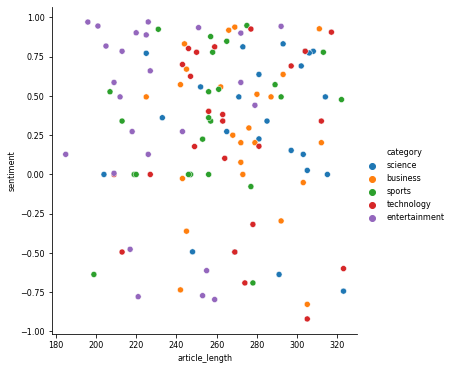

In [79]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = news_df, x = 'article_length', y = 'sentiment', hue = 'category')

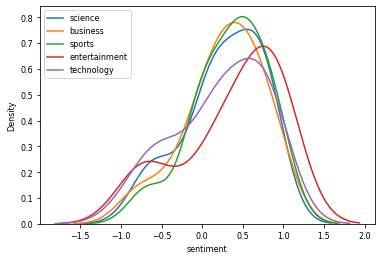

In [80]:
# is the distribution for sentiment different for ham vs spam
sns.kdeplot(news_df[news_df.category == 'science'].sentiment, label = 'science')
sns.kdeplot(news_df[news_df.category == 'business'].sentiment, label = 'business')
sns.kdeplot(news_df[news_df.category == 'sports'].sentiment, label = 'sports')
sns.kdeplot(news_df[news_df.category == 'entertainment'].sentiment, label = 'entertainment')
sns.kdeplot(news_df[news_df.category == 'technology'].sentiment, label = 'technology')
plt.legend(['science', 'business','sports','entertainment','technology'])

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/an

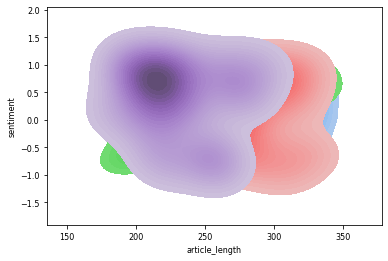

In [81]:
# Bivariate KDE plot for message_length vs sentiment score 
sns.kdeplot(news_df[news_df.category == 'science'].article_length,news_df[news_df.category == 'science'].sentiment, levels = 30, shade = True )
sns.kdeplot(news_df[news_df.category == 'business'].article_length,news_df[news_df.category == 'business'].sentiment, levels = 30, shade = True )
sns.kdeplot(news_df[news_df.category == 'sports'].article_length,news_df[news_df.category == 'sports'].sentiment, levels = 30, shade = True )
sns.kdeplot(news_df[news_df.category == 'technology'].article_length,news_df[news_df.category == 'technology'].sentiment, levels = 30, shade = True )
sns.kdeplot(news_df[news_df.category == 'entertainment'].article_length,news_df[news_df.category == 'entertainment'].sentiment, levels = 30, shade = True );

In [82]:
science_words

'mount etna eruption created volcanic storm sent bolts lightning across sky eastern sicily volcanic expert volcanic storms rare happen particularly violent eruptions volcanoes located near sea eruption took place earlier week shot ash 10 km air sea level nasa shared firstever images captured james webb space telescope includes selfie primary mirror one image mosaic released nasa shows 18 little white dots dot different view isolated star image included selfie telescope primary mirror nasa recently shared video showing infrared view north pole jupiter showed storms resembled pizza topping pepperoni calling phenomenon pepperoni storms nasa explained yellow areas warmer deeper jupiter atmosphere dark areas colder higher jupiter atmosphere countdown launch pslvc52 carrying three satellites began sunday morning scheduled monday 559 space agency first launch mission 2022 launch vehicle take satish dhawan space centre sriharikota andhra pradesh university cambridgeled researchers created 46in

In [83]:
pd.Series(science_words.split()).value_counts()

researchers    9
years          8
energy         8
found          8
nasa           8
              ..
20             1
israeli        1
however        1
flights        1
engineering    1
Length: 682, dtype: int64

In [84]:
pd.Series(business_words.split()).value_counts()

bajaj         15
crore         15
india         13
rahul          8
last           7
              ..
regulatory     1
harsh          1
cbi            1
integrate      1
gujarat        1
Length: 632, dtype: int64

In [87]:
tfidf = TfidfVectorizer()

In [88]:
X = tfidf.fit_transform(news_df.lemmatized)
y = news_df.category

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [91]:
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

## Baseline:
Use any one of the categories and use that as the baseline.

In [151]:
# baseline
news_df[news_df['category'] == 'science'].category.value_counts()/sum(news_df.category.value_counts())

science    0.203252
Name: category, dtype: float64

## Logistic Regression

In [93]:
lm = LogisticRegression().fit(X_train, y_train)

In [94]:
train['predicted'] = lm.predict(X_train)

In [95]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 97.96%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
predicted                                                          
business             20              0        0       0           0
entertainment         0             20        0       0           0
science               0              0       20       0           2
sports                0              0        0      19           0
technology            0              0        0       0          17
---
               precision    recall  f1-score   support

     business       1.00      1.00      1.00        20
entertainment       1.00      1.00      1.00        20
      science       0.91      1.00      0.95        20
       sports       1.00      1.00      1.00        19
   technology       1.00      0.89      0.94        19

     accuracy                           0.98        98
    macro avg       0.98      0.98      0.98        98
 weighted avg       0.98      0.98      

In [103]:
cross_val_score(lm, X_train, y_train, cv = 5)

array([0.9       , 0.6       , 0.65      , 0.84210526, 0.68421053])

In [143]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'train_accuracy'])
eval_df

,model_type,target_var,train_accuracy


In [144]:
eval_df = eval_df.append({'model_type':'Logistic Regression', 'target_var':'category', 'train_accuracy':accuracy_score(train.actual, train.predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,category,0.979592


## Decision Tree

In [100]:
# Make and fit the object
dtc = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
# Use the object
train['dt_predicted'] = dtc.predict(X_train)
# Determine performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.dt_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.dt_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.dt_predicted))

Accuracy: 57.14%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
dt_predicted                                                       
business              8              0        0       0           0
entertainment         0             11        0       0           0
science              12              9       20       2          19
sports                0              0        0      17           0
---
               precision    recall  f1-score   support

     business       1.00      0.40      0.57        20
entertainment       1.00      0.55      0.71        20
      science       0.32      1.00      0.49        20
       sports       1.00      0.89      0.94        19
   technology       0.00      0.00      0.00        19

     accuracy                           0.57        98
    macro avg       0.66      0.57      0.54        98
 weighted avg       0.67      0.57      0.54        98



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
cross_val_score(dtc, X_train, y_train, cv = 5)

array([0.6       , 0.6       , 0.55      , 0.57894737, 0.36842105])

In [146]:
eval_df = eval_df.append({'model_type':'Decision Tree Classifier - max depth = 3', 'target_var':'category', 'train_accuracy':accuracy_score(train.actual, train.dt_predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,category,0.979592
1,Decision Tree Classifier - max depth = 3,category,0.979592
2,Decision Tree Classifier - max depth = 3,category,0.571429


## Random Forest

In [135]:
# Make and fit object
rf = RandomForestClassifier(bootstrap = True, 
                            class_weight = None, 
                            criterion = 'gini',
                            min_samples_leaf = 3,
                            n_estimators = 100,
                            max_depth = 7, 
                            random_state = 123).fit(X_train, y_train)
# Use it to make predictions
train['rf_predicted'] = rf.predict(X_train)
# Assess performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.rf_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.rf_predicted))

Accuracy: 87.76%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
rf_predicted                                                       
business             19              0        0       1           2
entertainment         0             18        0       0           0
science               1              1       20       0           5
sports                0              0        0      18           1
technology            0              1        0       0          11
---
               precision    recall  f1-score   support

     business       0.86      0.95      0.90        20
entertainment       1.00      0.90      0.95        20
      science       0.74      1.00      0.85        20
       sports       0.95      0.95      0.95        19
   technology       0.92      0.58      0.71        19

     accuracy                           0.88        98
    macro avg       0.89      0.88      0.87        98
 weighted avg       0.89      0.88      

In [136]:
cross_val_score(rf, X_train, y_train, cv = 5)

array([0.7       , 0.65      , 0.7       , 0.68421053, 0.73684211])

In [147]:
eval_df = eval_df.append({'model_type':'Random Forest Classifier - min samples = 3, max depth = 7', 'target_var':'category', 'train_accuracy':accuracy_score(train.actual, train.rf_predicted)}, ignore_index = True)
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,category,0.979592
1,Decision Tree Classifier - max depth = 3,category,0.979592
2,Decision Tree Classifier - max depth = 3,category,0.571429
3,"Random Forest Classifier - min samples = 3, max depth = 7",category,0.877551


## KNN

In [139]:
# Make and fit the object
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_train, y_train)
# Use the object 
train['knn_predicted'] = knn.predict(X_train)
# Evaluate performance
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.knn_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.knn_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.knn_predicted))

Accuracy: 87.76%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
knn_predicted                                                      
business             18              0        0       0           4
entertainment         0             19        1       0           0
science               1              0       19       0           4
sports                0              0        0      19           0
technology            1              1        0       0          11
---
               precision    recall  f1-score   support

     business       0.82      0.90      0.86        20
entertainment       0.95      0.95      0.95        20
      science       0.79      0.95      0.86        20
       sports       1.00      1.00      1.00        19
   technology       0.85      0.58      0.69        19

     accuracy                           0.88        98
    macro avg       0.88      0.88      0.87        98
 weighted avg       0.88      0.88      

In [140]:
cross_val_score(knn, X_train, y_train, cv = 5)

array([0.75      , 0.75      , 0.6       , 0.84210526, 0.68421053])

In [148]:
eval_df = eval_df.append({'model_type':'KNN - neighbors = 4', 'target_var':'category', 'train_accuracy':accuracy_score(train.actual, train.knn_predicted)}, ignore_index = True)


In [149]:
eval_df

,model_type,target_var,train_accuracy
0,Logistic Regression,category,0.979592
1,Decision Tree Classifier - max depth = 3,category,0.979592
2,Decision Tree Classifier - max depth = 3,category,0.571429
3,"Random Forest Classifier - min samples = 3, max depth = 7",category,0.877551
4,KNN - neighbors = 4,category,0.877551


## Suppport Vector Classifier

In [117]:
# Make and fit the object
svc = LinearSVC(random_state=0).fit(X_train, y_train)
# Use the object
train['svc_predicted'] = svc.predict(X_train)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.svc_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.svc_predicted, train.actual))
print('---')
print(classification_report(train.actual, train.svc_predicted))

Accuracy: 97.96%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
svc_predicted                                                      
business             20              0        0       0           0
entertainment         0             20        0       0           0
science               0              0       20       0           2
sports                0              0        0      19           0
technology            0              0        0       0          17
---
               precision    recall  f1-score   support

     business       1.00      1.00      1.00        20
entertainment       1.00      1.00      1.00        20
      science       0.91      1.00      0.95        20
       sports       1.00      1.00      1.00        19
   technology       1.00      0.89      0.94        19

     accuracy                           0.98        98
    macro avg       0.98      0.98      0.98        98
 weighted avg       0.98      0.98      

In [118]:
cross_val_score(svc, X_train, y_train, cv = 5)

array([0.9       , 0.75      , 0.6       , 0.89473684, 0.63157895])

# Takeaways
* The Random Forest with a max depth of 7 seems to be the best performing model.
* I will move forward with the Random Forest model.

# Test model:

In [150]:
# Create testing dataframe
test = pd.DataFrame(dict(actual=y_test))
test['rf_predicted'] = rf.predict(X_test)
# Evaluate model
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.rf_predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.rf_predicted, test.actual))
print('---')
print(classification_report(test.actual, test.rf_predicted))

Accuracy: 68.00%
---
Confusion Matrix
actual         business  entertainment  science  sports  technology
rf_predicted                                                       
business              3              0        0       0           0
entertainment         0              3        0       0           0
science               0              2        5       0           4
sports                0              0        0       5           0
technology            2              0        0       0           1
---
               precision    recall  f1-score   support

     business       1.00      0.60      0.75         5
entertainment       1.00      0.60      0.75         5
      science       0.45      1.00      0.62         5
       sports       1.00      1.00      1.00         5
   technology       0.33      0.20      0.25         5

     accuracy                           0.68        25
    macro avg       0.76      0.68      0.68        25
 weighted avg       0.76      0.68      

# Takeaways
* The model beat baseline by 240%